# Анализ сервиса аренды самокатов GoFast

# Описание проекта

Нам передали данные от популярного сервиса аренды самокатов GoFast,  о некоторых пользователях из нескольких городов, а также об их поездках. Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки 
    * абонентская плата отсутствует;
    * стоимость одной минуты поездки — 8 рублей;
    * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra 
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.

## Описание данных
В основных данных есть информация о пользователях, их поездках и подписках.



Пользователи — users_go.csv

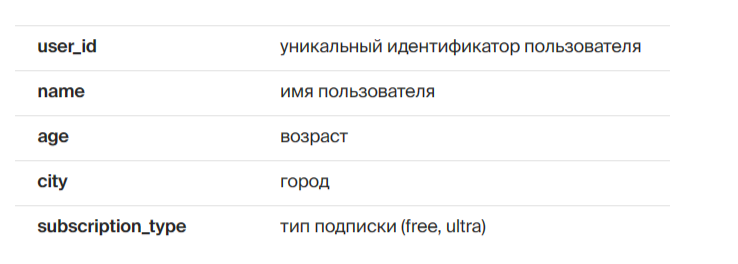

Поездки — rides_go.csv

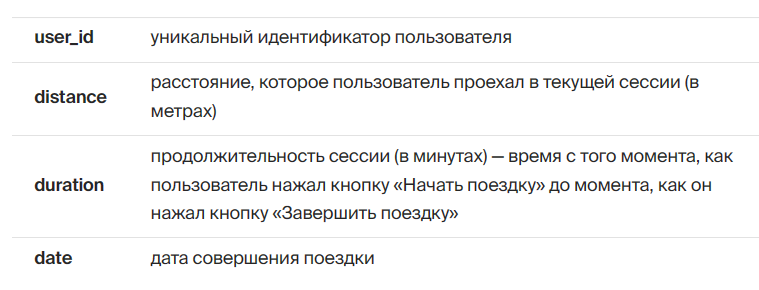

Подписки — subscriptions_go.csv

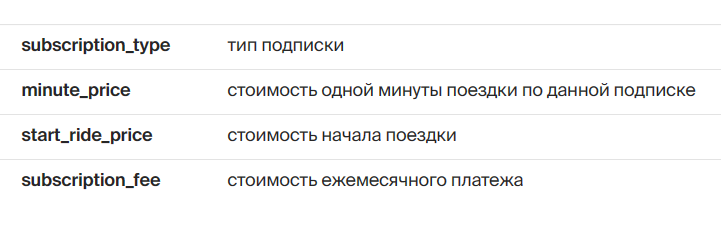

###  Загрузка данных

In [1]:
#импотритруем нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import scipy.stats as stats
from datetime import datetime

In [2]:
#подгружаем файл с данными
try:
    users=pd.read_csv('users_go.csv')
except:
    users=pd.read_csv('/datasets/users_go.csv')

try:
    rides_go=pd.read_csv('rides_go.csv')
except:
    rides_go=pd.read_csv('/datasets/rides_go.csv')

try:
    subscriptions_go=pd.read_csv('subscriptions_go.csv')
except:
    subscriptions_go=pd.read_csv('/datasets/subscriptions_go.csv')



In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides_go.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subscriptions_go.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subscriptions_go.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Предварительно изучили содержание датафреймов:
 - Таблица users содержит данные о пользователях, имеет 5 столбцов и 1565 строк
 - Таблица rides_go содержит данные о поездках пользователей, а именно расстояние, время и дата. Имеет 4 столбца и 18068 строк
 - Таблица subscriptions_go содержит данные о тарифах и подписках. Имеет 4 столбца и 2 строчки


###  Предобработка данных

Рассмотрим количество пропусков.

In [9]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [10]:
rides_go.isna().sum()

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [11]:
subscriptions_go.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

In [12]:
#приведем столбец date к типу даты 
rides_go['date']=pd.to_datetime(rides_go['date'])
#создаем новый столбец с номером месяца на основе столбца date
rides_go['month']=pd.to_datetime(rides_go['date']).dt.month

In [13]:
#проверим за кокой период представленны данные
rides_go['date'].dt.year.unique()

array([2021], dtype=int64)

In [14]:
#проверим на дубликаты
duplicates = users.duplicated().sum()
duplicates

31

In [15]:
duplicates = users[users.duplicated()]
duplicates

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


In [16]:
#удалим дубликаты
users.drop_duplicates(subset=None, keep="first", inplace=True)

In [17]:
duplicates = users.duplicated().sum()
duplicates

0

In [18]:
duplicates = rides_go.duplicated().sum()
duplicates

0

In [19]:
duplicates = subscriptions_go.duplicated().sum()
duplicates 

0

Пропущенных данных в таблицах нет.Дубликаты имеются среди пользователей, удалили строки-дубликаты.Привели столбец date к типу даты. Добавили столбец month с номер месяца.

###  Исследовательский анализ данных

In [20]:
#посмотрим список городов и количество пользователей в них 
sorted_users = users.groupby('city', as_index=False).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)
sorted_users

,city,user_id
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


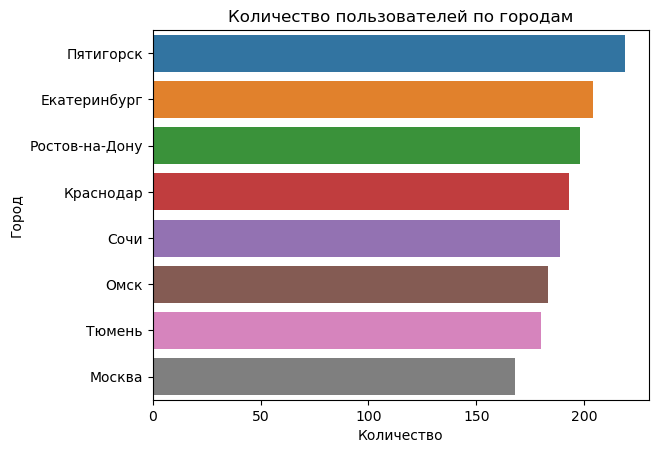

In [21]:
sns.barplot(x='user_id', y='city', data=sorted_users)
plt.title('Количество пользователей по городам')
plt.xlabel('Количество')
plt.ylabel('Город')
plt.show()

In [22]:
counts=users['subscription_type'].value_counts()
print(counts)

free     835
ultra    699
Name: subscription_type, dtype: int64


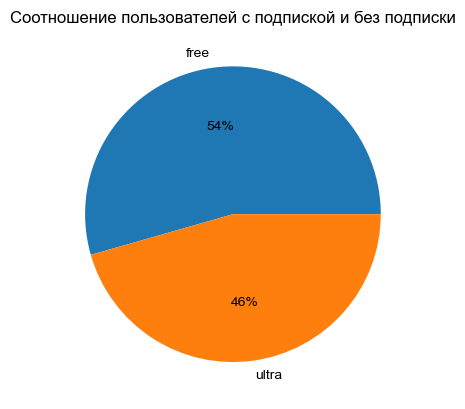

In [23]:
counts.plot(kind='pie', autopct='%1.0f%%', title='Соотношение пользователей с подпиской и без подписки')
sns.set(rc={'figure.figsize':(10,12)})
plt.ylabel('')
plt.xlabel('')
plt.show()

In [24]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

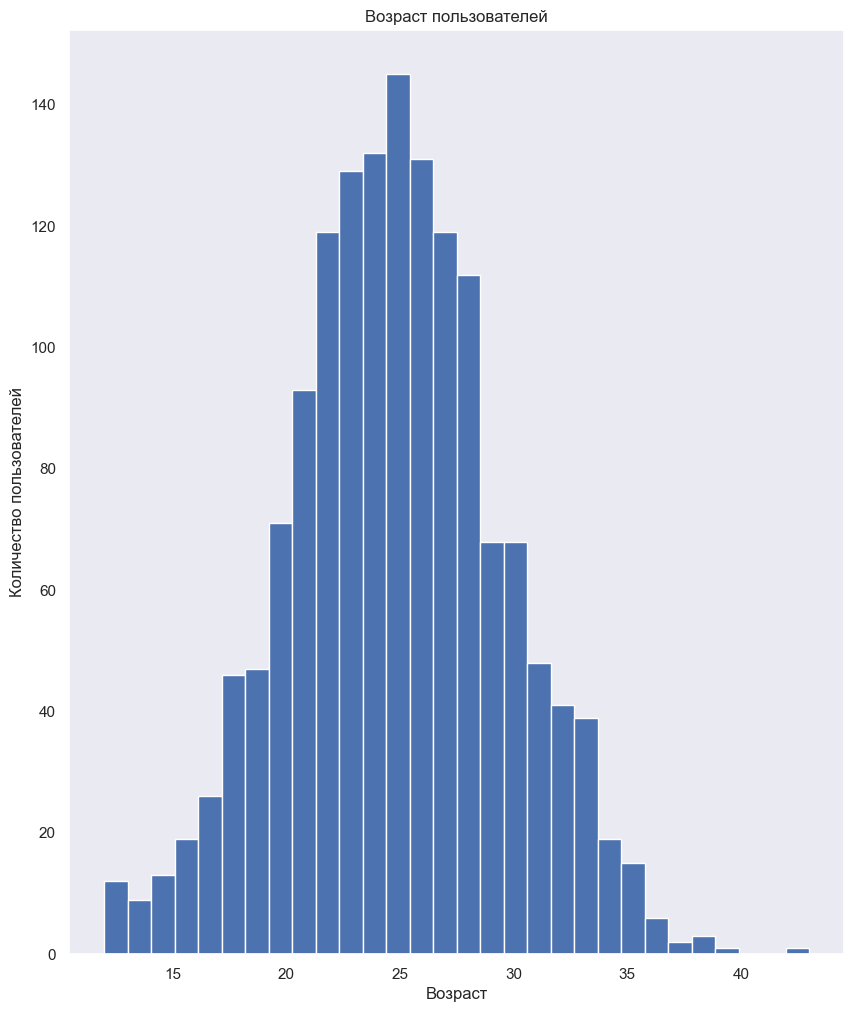

In [25]:
plt.hist(users['age'], bins = 30)
plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.grid()
plt.show()

In [26]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

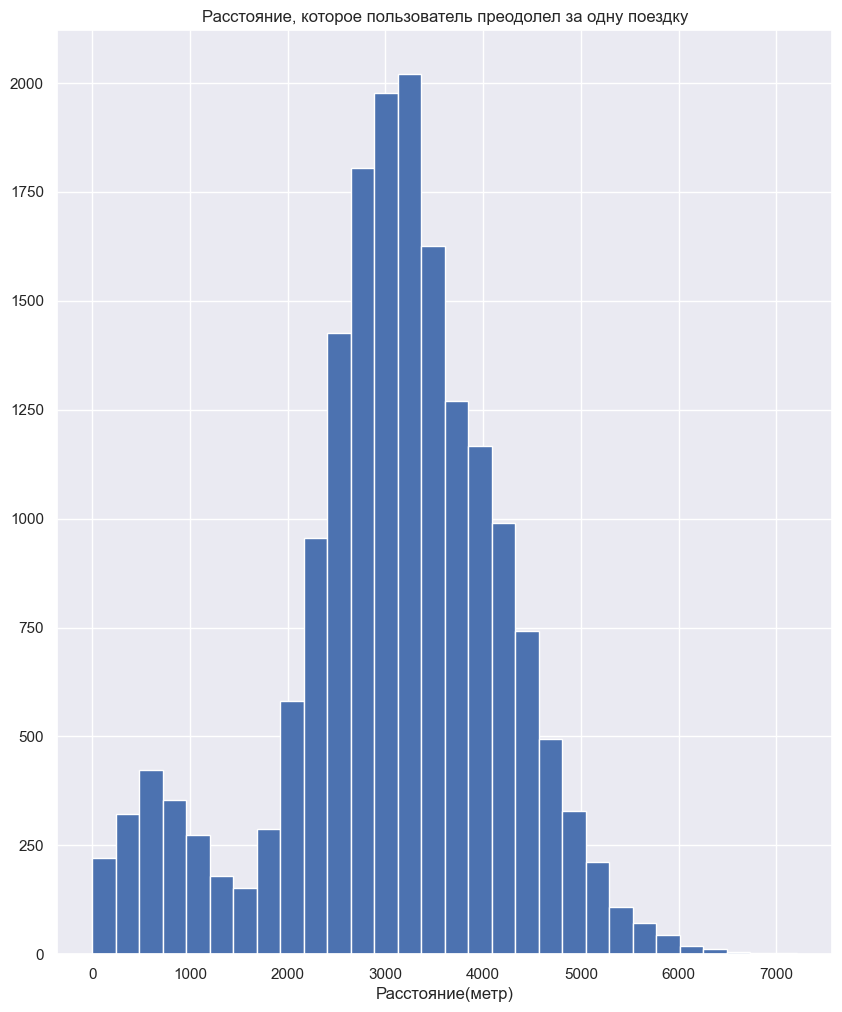

In [27]:
plt.hist(rides_go['distance'], bins = 30)
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.xlabel('Расстояние(метр)')
plt.show()

In [28]:
rides_go['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

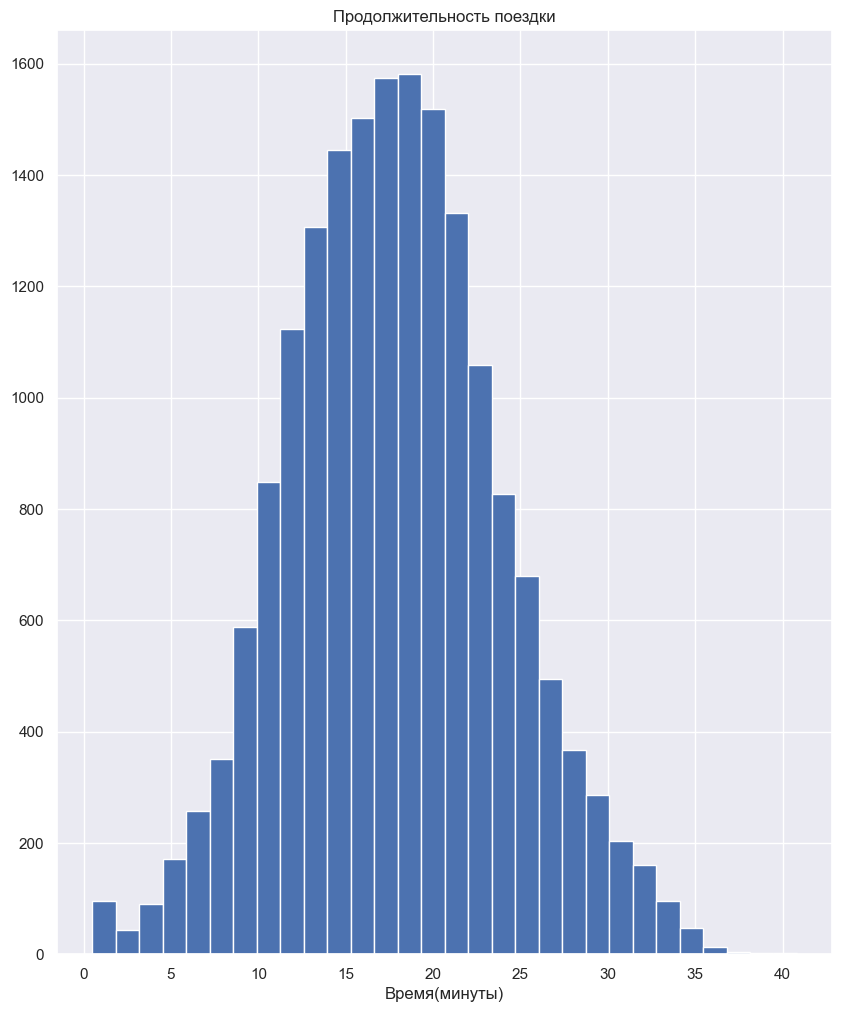

In [29]:
plt.hist(rides_go['duration'], bins = 30)
plt.title('Продолжительность поездки')
plt.xlabel('Время(минуты)')
plt.show()

Изучив таблицу ‘Users’ можно отметить:
-	Приложением пользуются в 8 городах. В основном Пятигорск-219 пользователей, минимально в Москве-168 пользователя.
-	Подписку ultra оформили 46% пользователя
-	Основной возраст пользователей -25 лет, минимальный возраст - 12 лет, максимальный 43 года.
-	Среднее длительность поездки в районе 3-х км, минимальный показатель меньше 1 км, максимально 7км.
-	Продолжительность поездки в среднем 17 минут, минимально меньше минуты, максимально 40 минут.


###  Объединение данных

In [30]:
#перед объединением проверим количество строк в таблице rides_go, ориентируемся по ней так как там максимальное количестов строк
print("Количество строк перед объединением:", rides_go.shape[0])

Количество строк перед объединением: 18068


In [31]:
#объединим таблицу с данными о пользователях и опездках в одну
data = users.merge(rides_go, how='left', on='user_id')

#присоединим к получившейся таблице таблицу с данными о тарифах
data = data.merge(subscriptions_go, how='left', on='subscription_type')

In [32]:
print("Количество строк в объединенной таблице:", data.shape[0])

Количество строк в объединенной таблице: 18068


In [33]:
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [34]:
#создаем датафрейм с данными о пользователях без подписки
free=data.query("`subscription_type` == 'free'")
free

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [35]:
free.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.000000,11568.000000,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.495282,17.390909,6.522994,8.0,50.0,0.0
std,241.165628,4.481100,1246.173806,6.326803,3.449770,0.0,0.0,0.0
min,700.000000,12.000000,0.855683,0.500000,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2366.562689,12.958437,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3114.648465,17.326890,7.000000,8.0,50.0,0.0
75%,1328.000000,28.000000,3905.697894,21.594071,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7211.007745,34.948498,12.000000,8.0,50.0,0.0


In [36]:
#Создадим датафрейм с данными о пользователях с подпиской
ultra = data.query("`subscription_type` == 'ultra'")
ultra

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8,6,0,199
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9,6,0,199
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9,6,0,199
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10,6,0,199


In [37]:
ultra.describe()

,user_id,age,distance,duration,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.445388,18.541985,6.422308,6.0,0.0,199.0
std,201.099339,4.757208,836.895330,5.572048,3.414616,0.0,0.0,0.0
min,1.000000,12.000000,244.210438,3.760353,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.444017,14.524654,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3148.637229,18.178153,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3560.574425,21.884129,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5699.769662,40.823963,12.000000,6.0,0.0,199.0


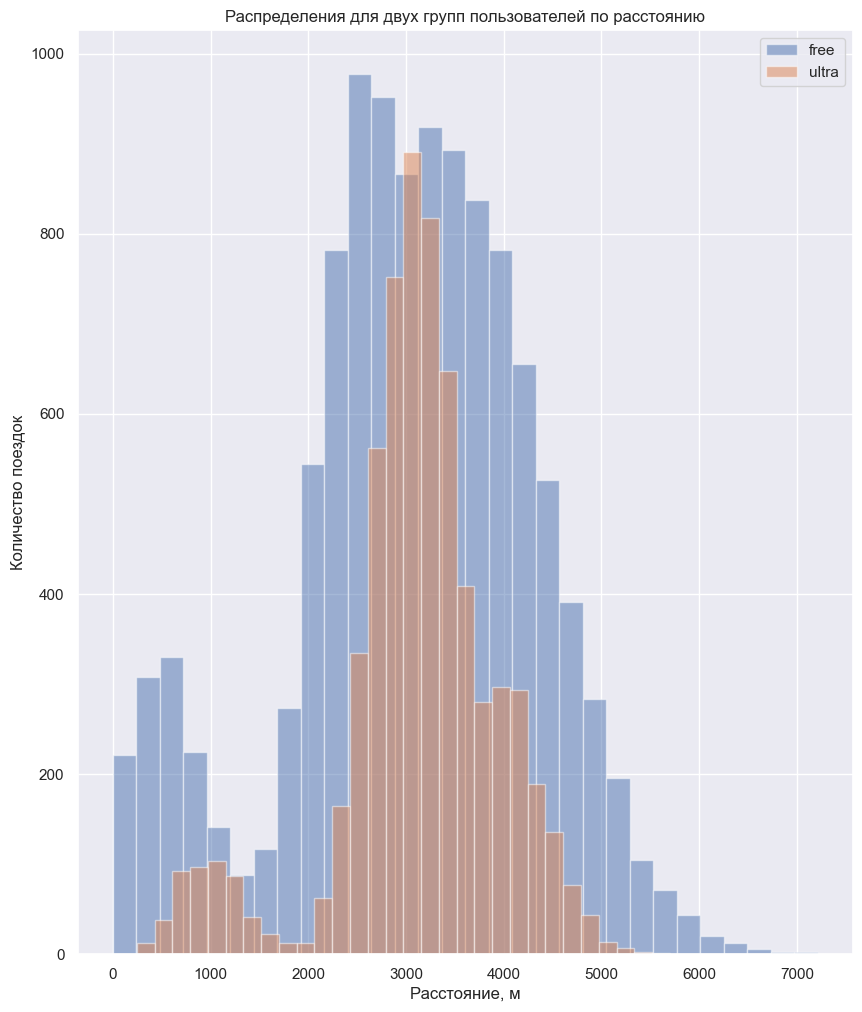

In [38]:
# Построение гистограммы для первой группы пользователей
plt.hist(free['distance'], bins=30, alpha=0.5, label='free')

# Построение гистограммы для второй группы пользователей
plt.hist(ultra['distance'], bins=30, alpha=0.5, label='ultra')

# Добавление легенды
plt.legend()

# Добавление названия осей
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')

# Добавление заголовка графика
plt.title('Распределения для двух групп пользователей по расстоянию')

# Отображение графика
plt.show()

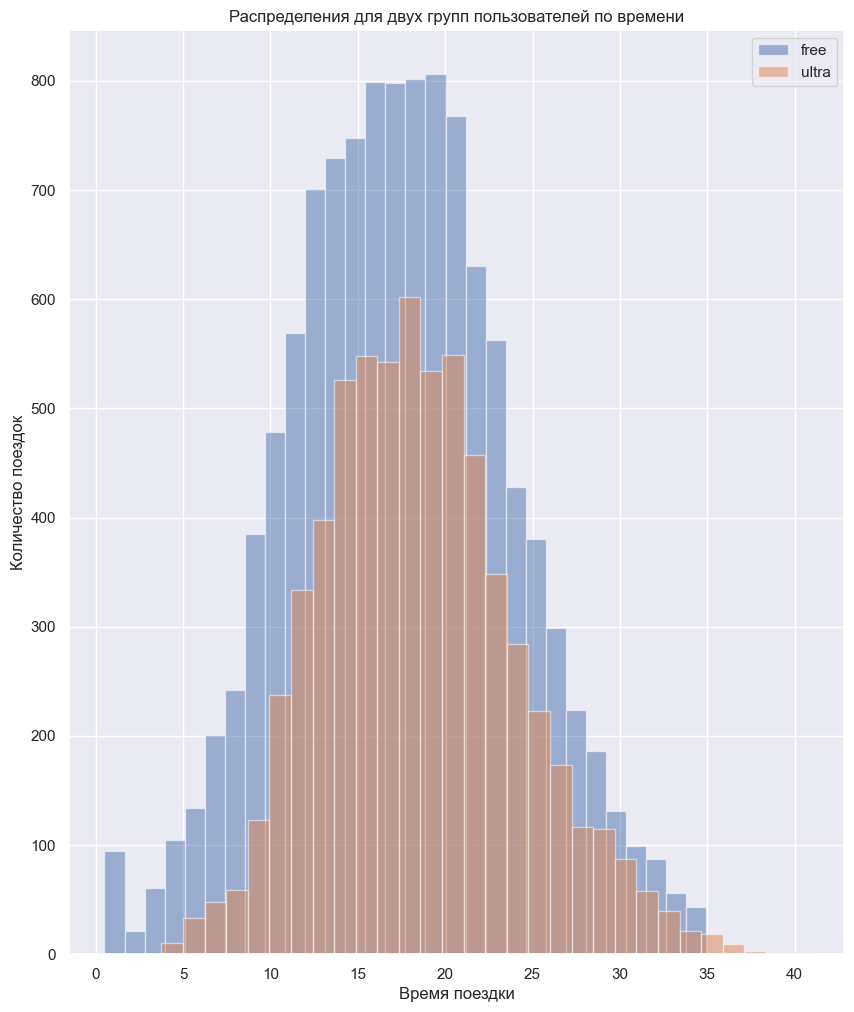

In [39]:
# Построение гистограммы для первой группы пользователей
plt.hist(free['duration'], bins=30, alpha=0.5, label='free')

# Построение гистограммы для второй группы пользователей
plt.hist(ultra['duration'], bins=30, alpha=0.5, label='ultra')

# Добавление легенды
plt.legend()

# Добавление названия осей
plt.xlabel('Время поездки')
plt.ylabel('Количество поездок')

# Добавление заголовка графика
plt.title('Распределения для двух групп пользователей по времени')

# Отображение графика
plt.show()

Объединили данные о пользователях, поездках и тарифах в один датафрейм - data. Выделили два датафрейма на основе data:

 - free - информация о пользователях с бесплатным тарифом
 - ultra - информация о пользователях с платным тарифом

На бесплатном тарифе чаще чем на платном ездят на большие расстояния, так в бесплатном тарифе максимальное расстояние это 7км, а в платном тарифе это 5км, если брать среднее значение, то оно одинаково для двух тарифов в среднем расстояние, на которое используют самокат это 3км. Если брать по времени пользования самокатом то в бесплатном тарифе также максимальное время использования это 34мин, а в платном 40 минут, среднее же время примерно одинаково 17-18 минут

Таким образом, можно сделать вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе.

###  Подсчет выручки

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [40]:
#округлим столбец 'duration' в датафрейме data
data['duration'] = np.ceil(data['duration'])

In [41]:
new_data = pd.pivot_table(data,
                           index=['month', 'user_id'],
                           values = ['distance', 'duration', 'name', 'subscription_type', 'minute_price','start_ride_price','subscription_fee' ],
                           aggfunc = {'distance': sum, 
                                      'duration' : sum, 
                                      'name' : len, 
                                      'subscription_type' : min,
                                      'month': min,
                                      'minute_price': min,
                                      'start_ride_price':min,
                                      'subscription_fee':min})
new_data.reset_index
new_data.tail(20)

distance  duration  minute_price  month  name  \
month user_id                                                      
12    1507      3251.983710      20.0             8     12     1   
      1508      1794.979054      12.0             8     12     1   
      1509       640.103734      16.0             8     12     1   
      1510      9548.405795      42.0             8     12     3   
      1511      3815.649136      34.0             8     12     1   
      1512       537.084007      15.0             8     12     1   
      1513      3221.460149      22.0             8     12     2   
      1514      1232.905308      17.0             8     12     1   
      1517     12338.591353      65.0             8     12     3   
      1518      3157.449947      31.0             8     12     1   
      1519      4645.742341      20.0             8     12     1   
      1521      9685.205958      29.0             8     12     2   
      1522      2887.841624      10.0             8     12     1   
      1523      5840.866245      27.0             8     12     2   
      1524      1610.268044      15.0             8     12     1   
      1525      4597.854350      34.0             8     12     1   
      1526      3644.121544      23.0             8     12     1   
      1528      3998.569324      11.0             8     12     1   
      1532      6111.889853      42.0             8     12     2   
      1534      2371.711192      16.0             8     12     1   

               start_ride_price  subscription_fee subscription_type  
month user_id                                                        
12    1507                   50                 0              free  
      1508                   50                 0              free  
      1509                   50                 0              free  
      1510                   50                 0              free  
      1511                   50                 0              free  
      1512                   50                 0              free  
      1513                   50                 0              free  
      1514                   50                 0              free  
      1517                   50                 0              free  
      1518                   50                 0              free  
      1519                   50                 0              free  
      1521                   50                 0              free  
      1522                   50                 0              free  
      1523                   50                 0              free  
      1524                   50                 0              free  
      1525                   50                 0              free  
      1526                   50                 0              free  
      1528                   50                 0              free  
      1532                   50                 0              free  
      1534                   50                 0              free

In [42]:
new_data.rename(columns = {'name' : 'count_tips'}, inplace = True)

In [43]:
new_data['revenue_per_month']=new_data['start_ride_price']*new_data['count_tips']+new_data['minute_price']*new_data['duration']+new_data['subscription_fee']
new_data.head()

distance  duration  minute_price  month  count_tips  \
month user_id                                                           
1     1        7027.511294      42.0             6      1           2   
      3        3061.777147      13.0             6      1           1   
      5        3914.646990      13.0             6      1           1   
      7        6478.080979      28.0             6      1           2   
      12       3577.151148      33.0             6      1           1   

               start_ride_price  subscription_fee subscription_type  \
month user_id                                                         
1     1                       0               199             ultra   
      3                       0               199             ultra   
      5                       0               199             ultra   
      7                       0               199             ultra   
      12                      0               199             ultra   

               revenue_per_month  
month user_id                     
1     1                    451.0  
      3                    277.0  
      5                    277.0  
      7                    367.0  
      12                   397.0

In [44]:
new_data.query('user_id == 1')

,,distance,duration,minute_price,month,count_tips,start_ride_price,subscription_fee,subscription_type,revenue_per_month
month,user_id,,,,,,,,,
1,1,7027.511294,42.0,6,1,2,0,199,ultra,451.0
4,1,754.159807,7.0,6,4,1,0,199,ultra,241.0
8,1,6723.470560,46.0,6,8,2,0,199,ultra,475.0
10,1,5809.911100,32.0,6,10,2,0,199,ultra,391.0
11,1,7003.499363,56.0,6,11,3,0,199,ultra,535.0
12,1,6751.629942,28.0,6,12,2,0,199,ultra,367.0


In [45]:
new_data.head(10)

distance  duration  minute_price  month  count_tips  \
month user_id                                                           
1     1        7027.511294      42.0             6      1           2   
      3        3061.777147      13.0             6      1           1   
      5        3914.646990      13.0             6      1           1   
      7        6478.080979      28.0             6      1           2   
      12       3577.151148      33.0             6      1           1   
      13       6687.987446      42.0             6      1           2   
      14       7699.643820      35.0             6      1           2   
      15       4187.621459      39.0             6      1           1   
      20       3516.719208      29.0             6      1           1   
      22       3058.692225      13.0             6      1           1   

               start_ride_price  subscription_fee subscription_type  \
month user_id                                                         
1     1                       0               199             ultra   
      3                       0               199             ultra   
      5                       0               199             ultra   
      7                       0               199             ultra   
      12                      0               199             ultra   
      13                      0               199             ultra   
      14                      0               199             ultra   
      15                      0               199             ultra   
      20                      0               199             ultra   
      22                      0               199             ultra   

               revenue_per_month  
month user_id                     
1     1                    451.0  
      3                    277.0  
      5                    277.0  
      7                    367.0  
      12                   397.0  
      13                   451.0  
      14                   409.0  
      15                   433.0  
      20                   373.0  
      22                   277.0

Создали новый датафрейм с агрегированными данными (new_data) на основе датафрейма с объединенными данными (data).Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. Также добавили столбец с помесячной выручкой, которую принес каждый пользователь.

###  Проверка гипотез

#### 1. Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

H_0: Время (duration) пользователей на подписке ultra = время (duration) пользователей на подписке free

H_1: Время (duration) пользователей на подписке ultra > время (duration) пользователей на подписке free

alpha = 0.05

In [46]:
ult = ultra['duration'] 

fr = free['duration']

results = st.ttest_ind(ult, 
                       fr,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


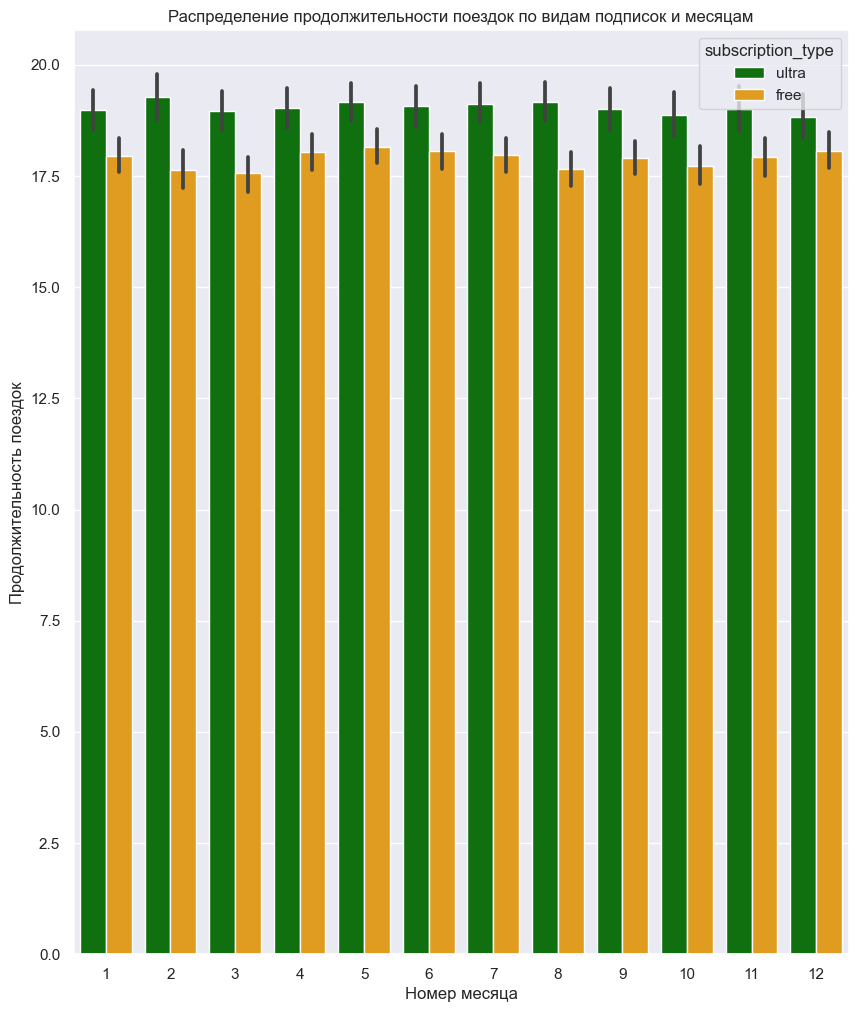

In [47]:
ax = sns.barplot(x = 'month',
            y = 'duration',
            hue = "subscription_type",
            data = data,
            palette = ['green', 'orange'])
ax.set_title('Распределение продолжительности поездок по видам подписок и месяцам')
ax.set(xlabel='Номер месяца', ylabel='Продолжительность поездок');
plt.show()

Проверили гипотезу, отвергли гипотезу о том, что время поездки пользователей на тарифе ultra равно времени поездки пользователей на тарифе free.Отвергли гипотезу что пользователи с подпиской тратят больше времени на поездки чем пользователи без подписки.

#### 2.Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Проверим гипотезу: пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку.

H_0: Расстояние (distance) пользователей на подписке ultra = 3130 метров

H_1: Расстояние (distance) пользователей на подписке ultra > 3130 метров

alpha = 0.05

In [48]:
ultra_dist = ultra['distance']
interested_value = 3130.0
alpha = .05
results = st.ttest_1samp(
    ultra_dist, 
    interested_value,
    alternative='greater')
print(results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


Проверили гипотезу, и мы не можем утверждать, что расстояние, которое проехали пользователи на тарифе ultra  превышает 3130 метров.

#### 3. Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Проверим гипотезу: помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки

H_0: Выручка (revenue_per_month) пользователей на подписке ultra = выручка (revenue_per_month) пользователей на подписке free

H_1: Выручка (revenue_per_month) пользователей на подписке ultra > выручка (revenue_per_month) пользователей на подписке free

alpha = 0.05

In [49]:
ultra_per_mnth = new_data.loc[new_data.subscription_type == 'ultra', 'revenue_per_month'] 

free_per_mnth = new_data.loc[new_data.subscription_type == 'free', 'revenue_per_month'] 


results = st.ttest_ind(ultra_per_mnth, 
                       free_per_mnth,
                       alternative = 'greater')

alpha = .05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Проверили гипотезу, соответственно, мы можем утверждать, что выручка с пользователей на подписке ultra превышает выручку с пользователей на подписке free

#### 4. Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Для этого нам понадобится гипотеза о равенстве средних для зависимых (парных) выборок.

Гипотезы будут сформулированы так:

H0 : μ1 = μ2

H1 : μ1 > μ2

где μ1 и μ2 - средние значения количество обращений в техподдержку до и после изменения.

Метод, который нужно использовать при сравнении: scipy.stats.ttest_rel()


###  Распределение.

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 
100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [50]:
# Параметры биномиального распределения
p = 0.10  # Вероятность успеха (продления подписки)
k = 100  # Минимальное количество клиентов, которые должны продлить подписку
desired_prob = 0.05  # Желаемая вероятность не выполнения плана (5%)

# Используем биномиальное распределение для нахождения минимального значения n
n = 1
while stats.binom.cdf(k - 1, n, p) > desired_prob:
    n += 1

print("Минимальное количество промокодов (n):", n)

Минимальное количество промокодов (n): 1161


Итак минимальное количество промокодов каторые нужно разослать, чтобы вероятность не выполнить план была примерно 5 % составляет 1161

# Вывод

Перед нами стояла задача изучить и проанализировать три датафрейма: информация о пользователях, их поездках и подписках.
Мы проверили все таблицы  на пропуски, их не оказалось ни в одной таблице. Выявили дубликаты, их оказалось меньше 5%, поэтомы мы их удалил. Поменяли тип данных у столбца date из датафрейма rides_go к типу даты. Также добавили столбец month с номером месяца. 

Провели исследовательский анализ. Изучив таблицу ‘users’ мы отметили:
- Приложением пользуются в 8 городах. В основном Пятигорск-219 пользователей, минимально в Москве-168 пользователя.
- Подписку ultra оформили 46% пользователя
- Основной возраст пользователей -25 лет, минимальный возраст - 12 лет, максимальный 43 года.
- Среднее длительность поездки в районе 3-х км, минимальный показатель меньше 1 км, максимально 7км.
- Продолжительность поездки в среднем 17 минут, минимально меньше минуты, максимально 40 минут.

Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма:

- Для пользователей с ultra подпиской
- Для пользователей с free подпиской

Сделали вывод, что пользователи с бесплатным тарифом в целом совершают более долгие поездки, а также проезжают большее расстояние, чем пользователи на платном тарифе.

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм total_data. Добавили в датафрейм total_data столбец с помесячной выручкой revenue_per_month.


Проверили гипотезы:

Пользователи с подпиской тратят больше времени на поездки, чем пользователи на бесплатном тарифе - Отвергли нулевую гипотезу.

Пользователи с подпиской проезжают расстояние, не превышающее 3130 метров за одну поездку - Не удалось отвергнуть нулевую гипотезу.

Помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки - Отвергли нулевую гипотезу.

Вычислили сколько промокодов нужно разослать пользователям при условии что вероятность не выполнить план была примерно 5 % - 1161. 


